In [325]:
import pandas as pd

df = pd.read_csv('/home/rnm/Dev/algotrading/algotrading_1/WIN@N_M5_202205300905_202601061830.csv', sep='\t')


# 1. Combine <DATE> and <TIME> into a single string column
df['Timestamp'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])

# 2. Set the new column as the DatetimeIndex
df.set_index('Timestamp', inplace=True)
df['Timestamp'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])

# 3. Rename columns to remove brackets (required by mplfinance)
df = df.rename(columns={
    '<OPEN>': 'Open',
    '<HIGH>': 'High',
    '<LOW>': 'Low',
    '<CLOSE>': 'Close',
    '<TICKVOL>': 'Volume'
})

print(df["Close"].iloc[:5])

Timestamp
2022-05-30 09:05:00    113440
2022-05-30 09:10:00    113570
2022-05-30 09:15:00    113495
2022-05-30 09:20:00    113645
2022-05-30 09:25:00    113515
Name: Close, dtype: int64


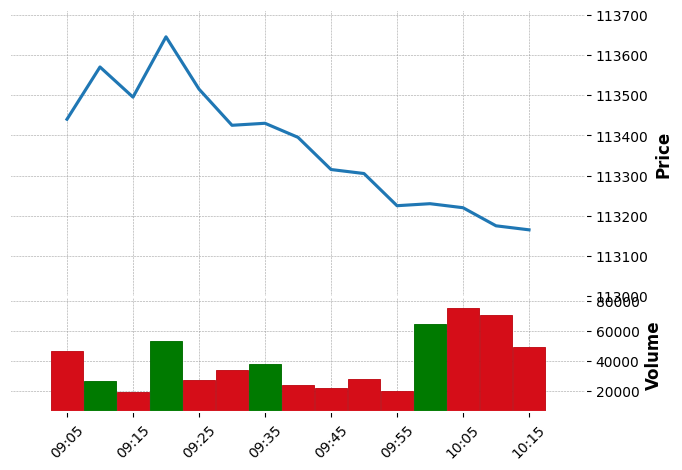

In [326]:
import mplfinance as mpf




filtered_df = df
# [(df.index > '2025-01-01') & (df.index < '2025-12-30')]
ohlc = filtered_df.to_dict(orient='records')

mpf.plot(filtered_df[:15], type='line', mav=(27), volume=True, style='charles')

In [327]:
from pprint import pprint
from typing import List, Optional
from pydantic import BaseModel

class Move(BaseModel):
    move: Optional[str] = None
    pb_type: Optional[str] = None
    bar_1: Optional[dict] = None
    bar_2: Optional[dict] = None




def main_direction(ohlc):
    prev = None
    move = None
    entries = []
    for item in ohlc:
        if prev is None:
            prev = item
            continue
        if prev.get('Close') < item.get('Close'):
            move= Move(move="up", pb_type=None, bar_1=prev, bar_2=item)
        elif prev.get('Close') > item.get('Close'):
            move= Move(move="down", pb_type=None, bar_1=prev, bar_2=item)
        else:
            move = Move(move="flat", pb_type=None, bar_1=prev, bar_2=item)
        prev = item
        entries.append(move)

    return entries

class Inflection(BaseModel):
    move: Optional[Move] = None
    bar: Optional[dict] = None

def bull_inflection(_move: List[Move], ohlc):
    prev = None
    interested_bull = [None, None, None]
    inflections_bull = []
    for move, bar in zip(_move, ohlc):
        if prev is None and move is not None and move.move == 'up':
            prev = move
            continue
        if prev is not None and move is not None:
            if interested_bull[0] is None and move.move == 'up':
                interested_bull = [move, move, move]
            elif prev.move == 'down' and move.move == 'up':
                interested_bull = [interested_bull[1], interested_bull[2], move.model_copy()]

        prev = move
        inflections_bull.append(interested_bull)
        # if interested_bear[0] is not None:
            # print(f"{interested_bear[0].bar_1.get('Timestamp')}, {interested_bear[1].bar_1.get('Timestamp')}, {interested_bear[2].bar_1.get('Timestamp')}, {bar.get('Timestamp')}")
    return inflections_bull

def bear_inflection(_move: List[Move], ohlc):
    prev = None
    prev_move_bear = None
    interested_bear = [None, None, None]
    inflections_bear = []
    for move, bar in zip(_move, ohlc):
        if prev is None and move is not None and move.move == 'down':
            prev = move
            continue
        if prev is not None and move is not None:
            if interested_bear[0] is None and move.move == 'down':
                interested_bear = [move, move, move]
            elif prev.move == 'up' and move.move == 'down':
                interested_bear = [interested_bear[1], interested_bear[2], move.model_copy()]

        prev = move
        inflections_bear.append(interested_bear)
        # if interested_bear[0] is not None:
        #     print(f"{interested_bear[0].bar_1.get('Timestamp')}, {interested_bear[1].bar_1.get('Timestamp')}, {interested_bear[2].bar_1.get('Timestamp')}, {bar.get('Timestamp')}")
    return inflections_bear

direction = main_direction(ohlc)
bull_inflections = bull_inflection(direction, ohlc)
bear_inflections = bear_inflection(direction, ohlc)
# pprint(bull_inflections)
# [print(item[0].bar_1.get("Timestamp")) if item[0] is not None else print("None") for item in bull_inflections]


In [328]:
def print_inflections(inflection, bar):
    if inflection[0] is None:
        print(None, None, None)
        return
    print(f"{inflection[0].bar_1.get('Timestamp')}, {inflection[1].bar_1.get('Timestamp')}, {inflection[2].bar_1.get('Timestamp')}, {bar.get('Timestamp')}")

def bull_bar_count(_move: List[Move], _infletions, _ohlc):
    highs = None
    for move, inflection, bar in zip(_move[:5], _infletions, _ohlc):
        if highs is None and move is not None:
            highs = inflection
            # print_inflections(highs, bar)
            continue
    
        # print_inflections(highs, bar)

    
bull_bar_count = bull_bar_count(direction, bear_inflections, ohlc)

In [329]:
def only_unique(seq):
    seen_keys = set()
    unique_objects = []

    for obj in seq:
        # Replace 'id' with your specific key
        if obj[0] is not None and obj[0].bar_2.get("Timestamp") not in seen_keys:
            unique_objects.append(obj)
            seen_keys.add(obj[0].bar_2.get("Timestamp"))
    
    return unique_objects

unique_entries = only_unique(bull_inflections)
# [print(item[0].bar_2.get("Timestamp")) if item[0] is not None else print("None") for item in unique_entries]

In [333]:
import copy

_unique_entries = copy.deepcopy(unique_entries)
stop = 2000
take = 2000

def entry_by_bar(entries, bar):
    entry = None
    if len(entries) > 0 and len(entries[0]) > 0:
        entry = entries[0][0]
    else:
        return None, entries

    if entry is not None and bar.get("Timestamp") == entry.bar_2.get("Timestamp"):
        return entries.pop(0).pop(0), entries
    else:
        return None, entries


def execute_buy(_entries, _ohlc):
    global stop, take
    positions: list[Move] = []
    results = []
    outside = []

    _loop = _ohlc
    for idx, bar in enumerate(_loop):
        if len(_loop) == idx + 1:
            break
        # Check if theres an entry for that bar
        # Put entry in a list
        # Remove entry from set
        entry, _entries = entry_by_bar(_entries, bar)
        # print(entry)
        if entry is not None:
            positions.append(entry)

        for position in positions:
            # Check if its the entry bar
            if position.bar_2.get("Timestamp") == bar.get("Timestamp"):
                continue
            # Check if it reached stop
            stop_distance = position.bar_2.get("Close") - bar.get("Low")
            take_distance = bar.get("High") - position.bar_2.get("Close")
            # print(stop_distance, take_distance)
            if take_distance >= take and stop_distance >= stop:
                outside.append({
                    "Type": "outside",
                    "Bar": bar,
                    "Position": position
                })
                # Remove position from list
                positions.remove(position)
                continue
            if stop_distance > 0 and stop_distance >= stop:
                # Save as loss
                results.append({
                    "Type": "loss",
                    "Bar": bar,
                    "Position": position
                })
                # Remove position from list
                positions.remove(position)
            elif take_distance > 0 and take_distance >= take:
                # Save as profit
                results.append({
                    "Type": "profit",
                    "Bar": bar,
                    "Position": position
                })
                # Remove position from list
                positions.remove(position)

    # print(results)
    return results, outside

results, outside = execute_buy(_unique_entries, ohlc)
# pprint(results)
def pnl(results):
    profits = 0
    losses = 0
    seq = [1 if result.get("Type") == "profit" else -1 for result in results]
    return seq

seq = pnl(results)
# print(seq)
# print(len(seq))
pprint(results[1100:1110])


[{'Bar': {'<DATE>': '2022.07.28',
          '<SPREAD>': 5,
          '<TIME>': '16:10:00',
          '<VOL>': 95437,
          'Close': 103245,
          'High': 103270,
          'Low': 103150,
          'Open': 103250,
          'Timestamp': Timestamp('2022-07-28 16:10:00'),
          'Volume': 27664},
  'Position': Move(move='up', pb_type=None, bar_1={'<DATE>': '2022.07.27', '<TIME>': '13:35:00', 'Open': 101285, 'High': 101295, 'Low': 101205, 'Close': 101210, 'Volume': 20943, '<VOL>': 70702, '<SPREAD>': 5, 'Timestamp': Timestamp('2022-07-27 13:35:00')}, bar_2={'<DATE>': '2022.07.27', '<TIME>': '13:40:00', 'Open': 101210, 'High': 101285, 'Low': 101165, 'Close': 101240, 'Volume': 30214, '<VOL>': 102402, '<SPREAD>': 5, 'Timestamp': Timestamp('2022-07-27 13:40:00')}),
  'Type': 'profit'},
 {'Bar': {'<DATE>': '2022.07.28',
          '<SPREAD>': 5,
          '<TIME>': '16:25:00',
          '<VOL>': 97720,
          'Close': 103330,
          'High': 103385,
          'Low': 103305,
      

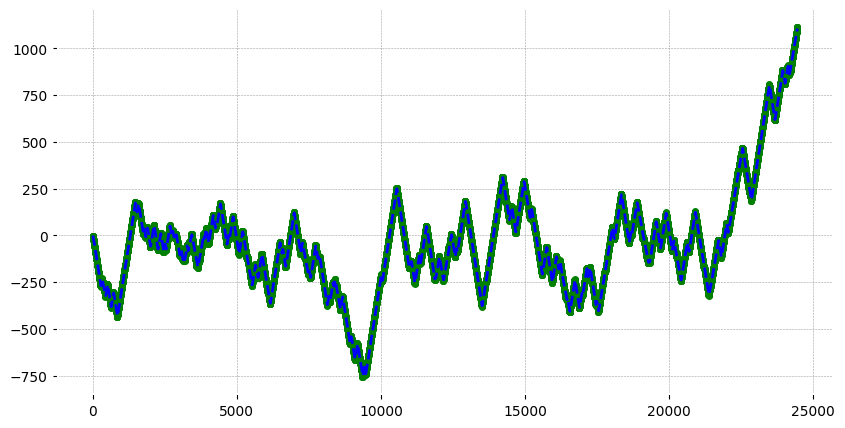

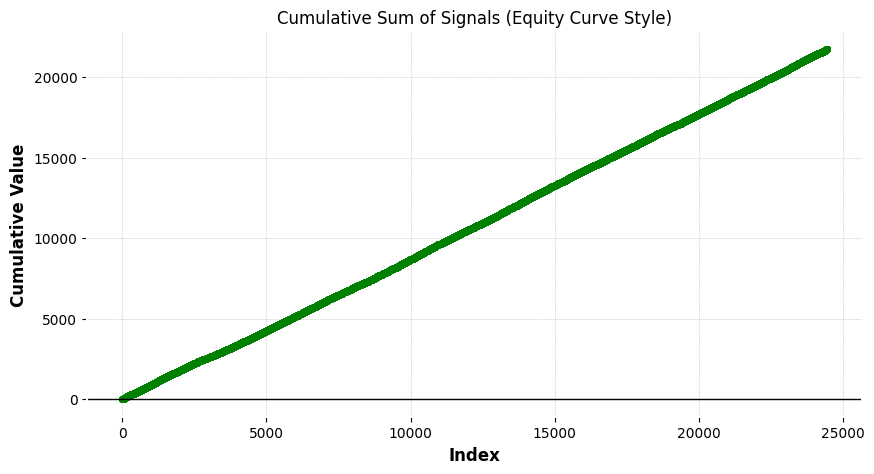

In [331]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate cumulative sum
cumulative_sum = np.cumsum(seq)
df = pd.DataFrame({
    'cumulative_sum': cumulative_sum,
    'seq': seq
})
df['MA20'] = df['cumulative_sum'].rolling(window=20, min_periods=1).mean().shift(1)
df['cumsum_s1'] = df['cumulative_sum'].shift(1)

# 3. Generate New Sequence based on rules
def apply_rules(row):
    val = row['seq']
    cum = row['cumsum_s1']
    ma = row['MA20']
    
    # Rule: 1 if > moving average
    if cum >= ma:
        return val
    # Rule: if item is -1 but < moving average invert to 1
    if cum < ma:
        return -val


df['New_Sequence'] = df.apply(apply_rules, axis=1)
df['New_Sequence_Cumsum'] = df['New_Sequence'].cumsum()


# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(range(len(df['cumsum_s1'])), df['cumsum_s1'], marker='o', linestyle='-', color='green', markersize=4)
plt.plot(range(len(df['MA20'])), df['MA20'], color='blue', linestyle='--', label='MA20')

plt.figure(figsize=(10, 5))
plt.plot(range(len(df['New_Sequence_Cumsum'])), df['New_Sequence_Cumsum'], marker='o', linestyle='-', color='green', markersize=4)

# Styling
plt.title("Cumulative Sum of Signals (Equity Curve Style)")
plt.xlabel("Index")
plt.ylabel("Cumulative Value")
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(0, color='black', linewidth=1)

plt.savefig('cumulative_plot.png')

In [332]:
df["New_Sequence_pts"] = df["New_Sequence"] * take
df["New_Sequence_pts_cum"] = df["New_Sequence_pts"].cumsum()
print(df.tail())

       cumulative_sum  seq    MA20  cumsum_s1  New_Sequence  \
24445            1112    1  1101.5     1111.0           1.0   
24446            1113    1  1102.5     1112.0           1.0   
24447            1114    1  1103.5     1113.0           1.0   
24448            1115    1  1104.5     1114.0           1.0   
24449            1116    1  1105.5     1115.0           1.0   

       New_Sequence_Cumsum  New_Sequence_pts  New_Sequence_pts_cum  
24445              21743.0            2000.0            43486000.0  
24446              21744.0            2000.0            43488000.0  
24447              21745.0            2000.0            43490000.0  
24448              21746.0            2000.0            43492000.0  
24449              21747.0            2000.0            43494000.0  


250: 1.329.000
350: 1.955.400
2000: 43.494.000